In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import os
import math
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score
import seaborn as sns
from sklearn import metrics
import time
import pickle
import metric_learn
from sklearn.decomposition import PCA  
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import LocalOutlierFactor
import functools
import tempfile
import datetime
import tensorflow as tf
import mlflow
from mlflow.models import infer_signature
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.python.client import device_lib; print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.list_physical_devices('GPU')
from utils import make_data, make_data_rev, make_label, calc_leq, leq_filter, validate, figure, figure_detail, plot_timeseries, fig_pr, auc_gs, fig_th_f

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15820032976734842041
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7459733504
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18202553843391500885
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2879431492706025071
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7459733504
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15688489359186630213
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
data_dir='filtered_csv_label'
original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df=df[df['day']<=9]
df

original  label  time  day
0            53.4      0    15    0
1            52.8      0    15    0
2            52.8      0    15    0
3            53.2      0    15    0
4            53.6      0    15    0
...           ...    ...   ...  ...
3995345      45.9      0     5    9
3995346      45.6      0     5    9
3995347      45.8      0     5    9
3995348      45.7      0     5    9
3995349      45.9      0     5    9

[3995350 rows x 4 columns]

# ホールドアウト検証
## 訓練、テストへ分割
* テスト（最終評価用）：6, 7, 8, 9 日目
---
ラベル付け
* 全体：0, 1, 2, 3, 4, 5 日目
* 訓練ローテ：(訓練、ラベル付与対象)=([0, 1, 2, 3, 4], 5)・・・([5, 0, 1, 2, 3], 4)

In [3]:
test_day=[6, 7, 8, 9]
semi_train_day=[0, 1, 2, 3, 4, 5]

test_df=df[(df['day'].isin(test_day))].reset_index(drop=True)
semi_train_df=df[(df['day'].isin(semi_train_day))].reset_index(drop=True)

In [4]:
df_list=[]

window=15
for i in set(df['day']):
    lag=[] 
    lag.append(make_data(semi_train_df.loc[semi_train_df['day']==i, ['original']], 'original', window))
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['day']])
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['label']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
semi_train_df=pd.concat(df_list)
semi_train_df=semi_train_df.dropna().reset_index(drop=True)
semi_train_df.loc[:, 'aed']=0
semi_train_df.loc[:, 'aed_label']=0

In [5]:
semi_train_df

original  original_lag1  original_lag2  original_lag3  original_lag4  \
0            54.9           55.0           55.7           55.8           55.6   
1            54.9           54.9           55.0           55.7           55.8   
2            54.9           54.9           54.9           55.0           55.7   
3            55.0           54.9           54.9           54.9           55.0   
4            55.0           55.0           54.9           54.9           54.9   
...           ...            ...            ...            ...            ...   
2393321      45.0           45.4           45.1           44.8           45.4   
2393322      45.2           45.0           45.4           45.1           44.8   
2393323      45.1           45.2           45.0           45.4           45.1   
2393324      45.1           45.1           45.2           45.0           45.4   
2393325      46.0           45.1           45.1           45.2           45.0   

         original_lag5  original_lag6  original_lag7  original_lag8  \
0                 55.7           55.5           55.7           54.7   
1                 55.6           55.7           55.5           55.7   
2                 55.8           55.6           55.7           55.5   
3                 55.7           55.8           55.6           55.7   
4                 55.0           55.7           55.8           55.6   
...                ...            ...            ...            ...   
2393321           45.6           45.0           45.7           45.1   
2393322           45.4           45.6           45.0           45.7   
2393323           44.8           45.4           45.6           45.0   
2393324           45.1           44.8           45.4           45.6   
2393325           45.4           45.1           44.8           45.4   

         original_lag9  original_lag10  original_lag11  original_lag12  \
0                 54.0            53.6            53.2            52.8   
1                 54.7            54.0            53.6            53.2   
2                 55.7            54.7            54.0            53.6   
3                 55.5            55.7            54.7            54.0   
4                 55.7            55.5            55.7            54.7   
...                ...             ...             ...             ...   
2393321           44.9            44.9            45.2            44.6   
2393322           45.1            44.9            44.9            45.2   
2393323           45.7            45.1            44.9            44.9   
2393324           45.0            45.7            45.1            44.9   
2393325           45.6            45.0            45.7            45.1   

         original_lag13  original_lag14  day  label  aed  aed_label  
0                  52.8            53.4    0      0    0          0  
1                  52.8            52.8    0      0    0          0  
2                  53.2            52.8    0      0    0          0  
3                  53.6            53.2    0      0    0          0  
4                  54.0            53.6    0      0    0          0  
...                 ...             ...  ...    ...  ...        ...  
2393321            45.0            45.2    5      0    0          0  
2393322            44.6            45.0    5      0    0          0  
2393323            45.2            44.6    5      0    0          0  
2393324            44.9            45.2    5      0    0          0  
2393325            44.9            44.9    5      0    0          0  

[2393326 rows x 19 columns]

## オートエンコーダでラベル付与

In [6]:
input_size=10
intermediate_dim=7
latent_dim=4

class AnomalyDetector(Model):
    def __init__(self):
        super().__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(input_size, activation="relu", input_shape=(window,)),
            layers.Dense(intermediate_dim, activation="relu"),
            layers.Dense(latent_dim, activation="relu")])
        self.decoder = tf.keras.Sequential([
            layers.Dense(intermediate_dim, activation="relu", input_shape=(latent_dim,)),
            layers.Dense(input_size, activation="relu"),
            layers.Dense(window, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

2024/01/07 18:30:26 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/01/07 18:30:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/01/07 18:30:27 INFO mlflow.tracking.fluent: Experiment with name 'custom_loss' does not exist. Creating a new experiment.
2024/01/07 18:30:27 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: 

訓練データ：[0, 1, 3, 4, 5]
ラベル付与データ：[2]日目


2024/01/07 18:30:29 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: The layer "anomaly_detector" has never been called and thus has no defined input shape. Note that the `input_shape` property is only available for Functional and Sequential models.
2024/01/07 18:30:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Arakawa\anaconda3\envs\tf291\lib\site-packages\mlflow\tensorflow\_autolog.py:52: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Epoch 1/5
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0186 - val_loss: 0.0122
Epoch 2/5
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0079 - val_loss: 0.0070
Epoch 3/5
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0067 - val_loss: 0.0070
Epoch 4/5
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0066 - val_loss: 0.0070
Epoch 5/5
7662/7662 [==============================] - 31s 4ms/step - loss: 0.0066 - val_loss: 0.0070


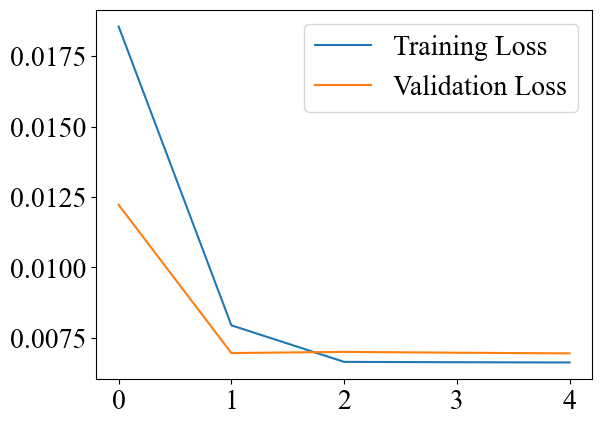

13500/13500 [==============================] - 16s 1ms/step
------------------------------------------------------


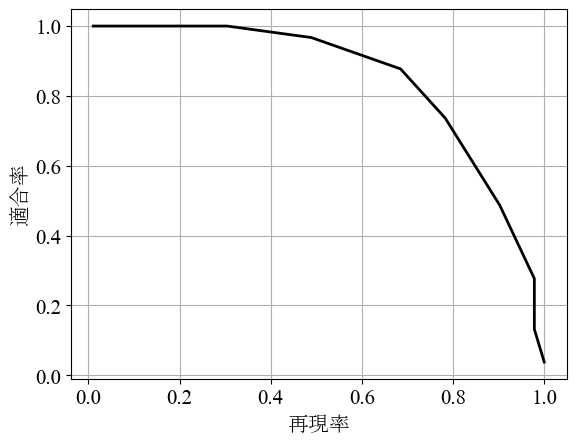

AUC：0.8387082696693833
理想の閾値：0.2
F値（最高）：0.7691860465116279
適合率（F値が最高の時）：0.8773209549071618
再現率（F値が最高の時）：0.6847826086956522
C:\Users\Arakawa\AppData\Local\Temp\tmpu6wsk7fy\predict_results.png


1/1 [==============================] - 0s 13ms/step
INFO:tensorflow:Assets written to: C:\Users\Arakawa\AppData\Local\Temp\tmptvt5o1at\model\data\model\assets


C:\Users\Arakawa\anaconda3\envs\tf291\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'autoencoder' already exists. Creating a new version of this model...
Created version '76' of model 'autoencoder'.


In [7]:
# remote_server_uri = "http://localhost:5000"  # set to your server URI
# mlflow.set_tracking_uri(remote_server_uri)
mlflow.autolog(log_models=False)

# 実験をアクティブ化(設定)する。ない場合は新たな実験を作成してアクティブ化する
mlflow.set_experiment("custom_loss")
run_name='no_custom'
with mlflow.start_run(run_name=run_name):

    # テストデータとする日
    i=[2]
    label_train_day=[k for k in semi_train_day if k not in i]
    label_grant_day=i
    print(f'訓練データ：{label_train_day}')
    print(f'ラベル付与データ：{label_grant_day}日目')
    # Log the hyperparameters
    mlflow.log_params({'trainday':label_train_day, 'testday':label_grant_day, 
                       'window_size':window, 'latent_dimension':latent_dim, 'inputlayer_size':input_size, 'intermediate_dim':intermediate_dim})

    semi_train_x=semi_train_df[(semi_train_df['day'].isin(label_train_day))][semi_train_df.columns[:-4]].reset_index(drop=True)
    labeling_x=semi_train_df[(semi_train_df['day'].isin(label_grant_day))][semi_train_df.columns[:-4]].reset_index(drop=True)
    # tf.reduce_min関数を使用して、train_dataテンソル内の最小値を計算しています。
    # min_valにはtrain_data内の最小値が代入されます。
    min_val = tf.reduce_min(semi_train_x)
    # tf.reduce_max関数を使用して、train_dataテンソル内の最大値を計算しています。
    # max_valにはtrain_data内の最大値が代入されます。
    max_val = tf.reduce_max(semi_train_x)
    train_data = (semi_train_x.values - min_val) / (max_val - min_val)
    labeling_data = (labeling_x.values - min_val) / (max_val - min_val)
    # データの型をtf.float32に変換
    train_data = tf.cast(train_data, tf.float32)
    
    labeling_data = tf.cast(labeling_data, tf.float32)
    autoencoder = AnomalyDetector()
    autoencoder.compile(optimizer='adam', loss='mae')
    
    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=10,
        restore_best_weights=True
    )
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    history = autoencoder.fit(train_data, train_data, 
          epochs=5, 
          batch_size=256,
          validation_data=(labeling_data, labeling_data),
          callbacks=[callback, tensorboard_callback],
          shuffle=True)
    
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.show()

    reconstructions = autoencoder.predict(labeling_data)
    #     異常度算出
    d= tf.keras.losses.mae(reconstructions, labeling_data).numpy()
    semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), 'aed']=d
    print('------------------------------------------------------')

    test_v=semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), ['original', 'label']].copy().reset_index(drop=True)
    d_test=(d-d.min())/(d.max()-d.min())

    thr_bins=20
    p_score, r_score, f_score, thresholds, thr, auc = fig_pr(test_v, d_test, thr_bins)
    f_max=f_score.max()
    p_max=p_score[np.argmax(f_score)]
    r_max=r_score[np.argmax(f_score)]
    print('\033[31m'+f'AUC：{auc}'+'\033[0m')
    print(f'理想の閾値：{thr}')
    print(f'F値（最高）：{f_max}')
    print(f'適合率（F値が最高の時）：{p_max}')
    print(f'再現率（F値が最高の時）：{r_max}')
    
    # Log the loss metric
    mlflow.log_metric("test_AUC", auc)
    mlflow.log_metric("test_Fscore_best", f_max)
    mlflow.log_metric("test_Precision_when Fscore Best", p_max)
    mlflow.log_metric("test_Recall_when Fscore Best", r_max)
    
    # 一時ディレクトリに予測結果のグラフを保存して，mlflowに送信する
    with tempfile.TemporaryDirectory()  as tmp:
        filename = os.path.join(tmp, "predict_results.png")
        plot_timeseries([test_v['original'].values], test_v['label'].values, d=d_test, thr=thr, mlflow=filename)
        mlflow.log_artifact(filename, artifact_path="plot_timeseries")
    
#     モデルの構造を定義しているソースコードを保存
    mlflow.log_artifact('autoencoder_HO.ipynb', artifact_path="source_code")    
    # Log the model
    signature= infer_signature(labeling_data.numpy()[:2], autoencoder.predict(labeling_data.numpy()[:2]))
    input_example= labeling_data.numpy()[:2]
    mlflow.tensorflow.log_model(
        autoencoder, 
        artifact_path="autoencoder",
        signature=signature,
        registered_model_name="autoencoder",
        input_example= input_example
    )

In [8]:
# Mlflow UI上で削除してもマシン上に実態は残っている
# 残ったデータを完全に削除する
! mlflow gc --backend-store-uri ./mlruns

In [9]:
! mlflow ui --port 5002 

^C
